In [1]:
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

In [2]:
from masterthesis.data import load_h5ad

# load the python AnnData object
anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/simdata_TS0.3_SS0.3.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/germ_sce.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/COVAC_POSTQC.h5ad")


**Simulated data is already preprocessed**

<BarContainer object of 7 artists>

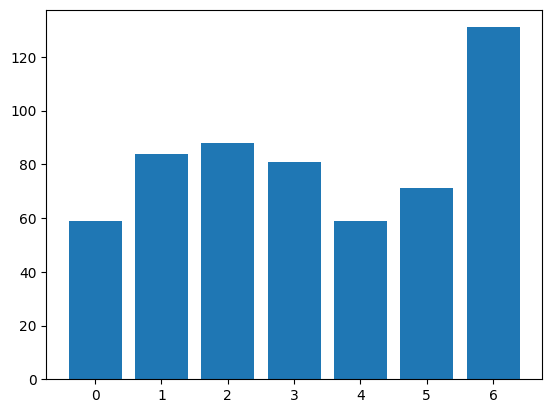

In [3]:
dat = np.unique(anndata.obs.Ordinal_Time_Labels, return_counts=True)
plt.bar(dat[0], dat[1])

In [4]:
from masterthesis.preprocessing import calculate_weights, transform_labels
from sklearn.model_selection import train_test_split

anndata.obs["ordinal_label"] = transform_labels(np.array([int(x) for x in anndata.obs.Ordinal_Time_Labels]))
X_train, X_test, y_train, y_test = train_test_split(anndata.X, anndata.obs["ordinal_label"], 
                                                    test_size=0.1, 
                                                    stratify=anndata.obs["ordinal_label"],
                                                    random_state=1234)

In [48]:
from masterthesis.model_selection import RegularizationGridSearch
from masterthesis.model import VanillaSGDBinarizedModel
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, log_loss

#reg_params = np.geomspace(1, 500, 20)
reg_params = np.geomspace(0.2, 0.01, 40) # strict regularization, training on all genes
weights_train = calculate_weights(y_train)
scoring = make_scorer(accuracy_score)
fit_params = {"sample_weight": weights_train}
estimator_params = {"early_stopping": True, "max_iter": 5} #"learning_rate": "constant"}

sgd = RegularizationGridSearch(estimator=VanillaSGDBinarizedModel, n_folds=5, n_jobs=4, lambdas=reg_params, scoring=scoring)
sgd.fit(X_train, y_train, estimator_params=estimator_params, fit_params=fit_params)

In [49]:
sgd.lambdas

array([0.2       , 0.18521248, 0.17151832, 0.15883667, 0.14709267,
       0.13621699, 0.12614543, 0.11681854, 0.10818126, 0.1001826 ,
       0.09277534, 0.08591576, 0.07956335, 0.07368063, 0.06823286,
       0.06318789, 0.05851593, 0.0541894 , 0.05018277, 0.04647238,
       0.04303632, 0.03985432, 0.03690759, 0.03417873, 0.03165164,
       0.02931139, 0.02714418, 0.0251372 , 0.02327862, 0.02155745,
       0.01996355, 0.01848749, 0.01712057, 0.01585472, 0.01468246,
       0.01359687, 0.01259155, 0.01166056, 0.01079841, 0.01      ])

Best idx: 38 Best Score: 0.21941747572815534 Best Lambda: 0.010798408271867899 Scores std: 0.017386435850093668
1SE idx: 8 1SE Score: 0.20388349514563106 1SE Lambda: 0.10818126309390201


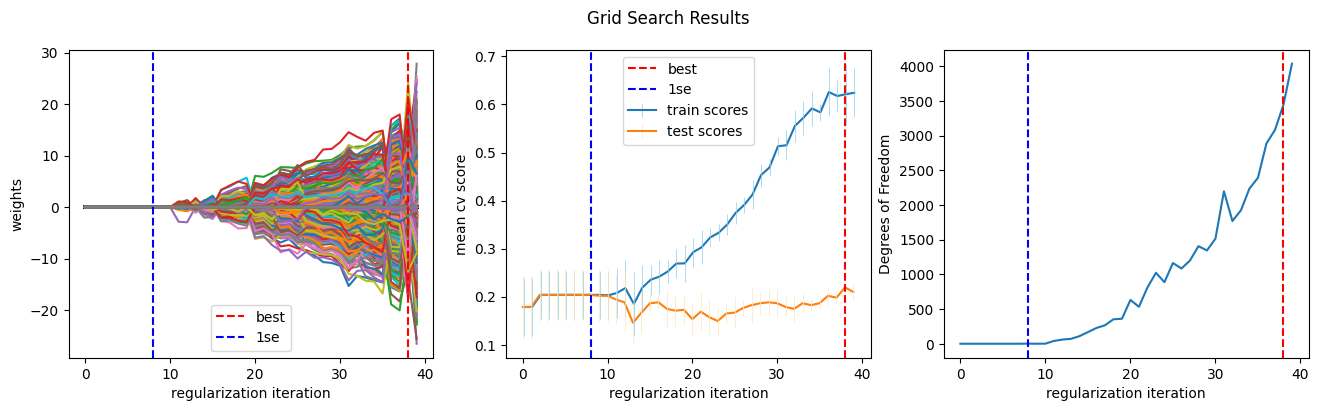

In [50]:
from masterthesis.plots import plot_grid_search
_ = plot_grid_search(sgd)

In [11]:
from masterthesis.model_selection import RegularizationGridSearch
from masterthesis.model import SGDBinarizedModel, LinearBinarizedModel
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, log_loss

reg_params = np.geomspace(1, 500, 20)
#reg_params = np.geomspace(1, 0.001, 20)
weights_train = calculate_weights(y_train)
scoring = make_scorer(accuracy_score)
fit_params = {"sample_weight": weights_train}
estimator_params = {"max_iter": 20}

fit_params = {}
estimator_params = {}

lin = RegularizationGridSearch(estimator=LinearBinarizedModel, n_folds=5, n_jobs=2, lambdas=reg_params, scoring=scoring)
lin.fit(X_train, y_train, fit_params=fit_params, estimator_params=estimator_params)

Best idx: 8 Best Score: 0.43106796116504853 Best Lambda: 13.690156816728805 Scores std: 0.039265093566876075
1SE idx: 8 1SE Score: 0.43106796116504853 1SE Lambda: 13.690156816728805


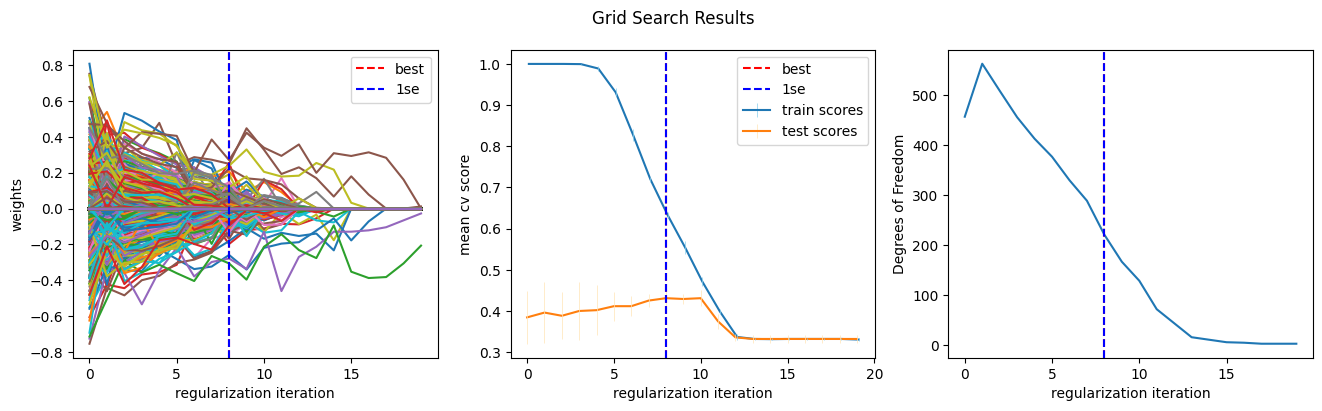

In [12]:
from masterthesis.plots import plot_grid_search
_ = plot_grid_search(lin)

In [51]:
sparse_model = sgd.get_optimal_model("1se")
sparse_model.fit(X_train, y_train)

VanillaSGDBinarizedModel(max_iter=5, regularization=0.10818126309390201)

Degrees of freedom 0
Train:
Accuracy: 0.229126213592233
Balanced accuracy: 0.14285714285714285
Mean absolute delta: 3.0
Test:
Accuracy: 0.22413793103448276
Balanced accuracy: 0.14285714285714285
Mean absolute delta: 3.0000000000000004


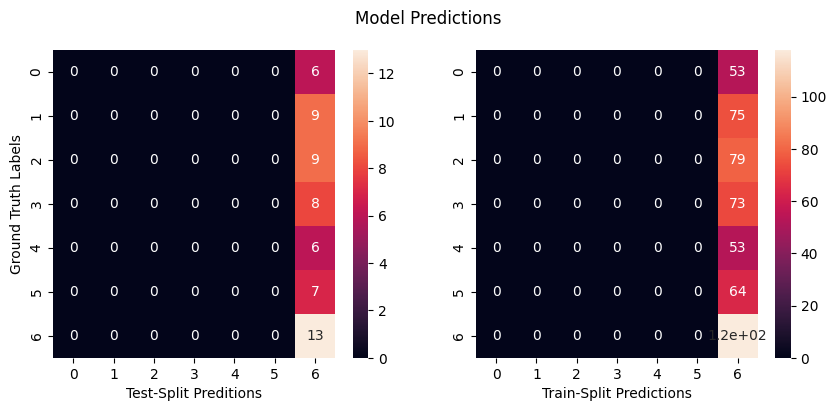

In [52]:
from masterthesis.plots import plot_model_perf
_ = plot_model_perf(sparse_model, test=(X_test, y_test), train=(X_train, y_train))

In [9]:
sparse_model.predict_psuper(anndata)
anndata.var["psupertime_weights"] = sparse_model.coef_

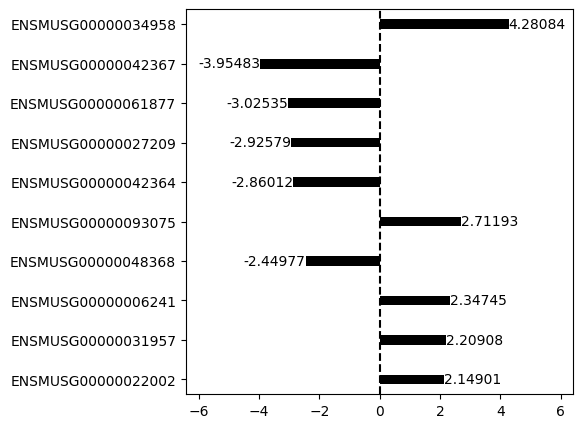

In [37]:
from masterthesis.plots import plot_identified_gene_coefficients

_ = plot_identified_gene_coefficients(sparse_model, anndata, n_top=10, figsize=(5,5))

# Plot labels over psupertime

In [11]:
print(sparse_model.intercept_)
print(sparse_model.binary_estimator_.intercept_)

[ 2.94578048  0.62306865  0.32695331  0.32695331  0.32695331 -0.84823786]
[0.32695331]


/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/masterthesis/plots.py:135: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=anndata.obs, x='psupertime', fill=label_key, hue=label_key, alpha=0.5,
/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/masterthesis/plots.py:135: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=anndata.obs, x='psupertime', fill=label_key, hue=label_key, alpha=0.5,
/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/masterthesis/plots.py:135: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=anndata.obs, x='psupertime', fill=label_key, hue=label_key, alpha=0.5,
/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/py

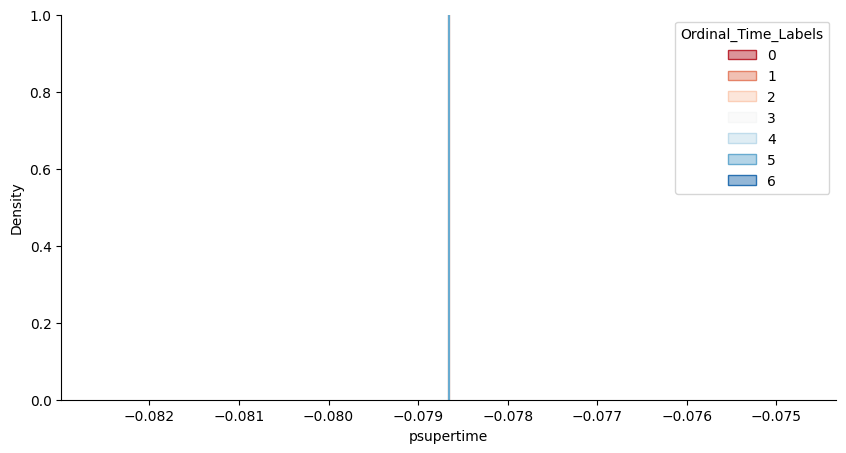

In [31]:
from masterthesis.plots import plot_labels_over_psupertime

_ = plot_labels_over_psupertime(sparse_model, anndata, "Ordinal_Time_Labels")


# Correlation with true latent time

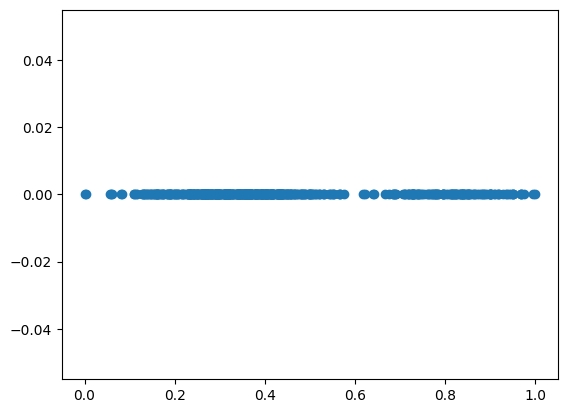

In [25]:
plt.scatter(anndata.obs.Latent_Time, anndata.obs.psupertime)

In [26]:
pearsonr = anndata.obs.Latent_Time.corr(anndata.obs.psupertime)
spearmanr = anndata.obs.Latent_Time.corr(anndata.obs.psupertime, method='spearman')
kendalltau = anndata.obs.Latent_Time.corr(anndata.obs.psupertime, method='kendall')
print("Pearson's correlation:", pearsonr)
print("Spearman's correlation:", spearmanr)
print("Kenall Tau:", kendalltau)

Pearson's correlation: nan
Spearman's correlation: nan
Kenall Tau: nan


/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
